In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pickle

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
!git clone https://github.com/rodrigorivera/mds20_deepfolio

Cloning into 'mds20_deepfolio'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 357 (delta 106), reused 0 (delta 0), pack-reused 197
Receiving objects: 100% (357/357), 19.36 MiB | 4.54 MiB/s, done.
Resolving deltas: 100% (175/175), done.


In [5]:
from mds20_deepfolio.models.NeuralHawkesProcess.DataWrapper import NHPDataset
from mds20_deepfolio.models.NeuralHawkesProcess.model import NHPModel
from mds20_deepfolio.models.NeuralHawkesProcess.utils import LogLikelihoodLoss, evaluate_prediction
from mds20_deepfolio.models.NeuralHawkesProcess.train import train, BeginningOfStream

!unzip /content/mds20_deepfolio/models/NeuralHawkesProcess/data/fin_data.zip \
      -d /content/mds20_deepfolio/models/NeuralHawkesProcess/data/


Archive:  /content/mds20_deepfolio/models/NeuralHawkesProcess/data/fin_data.zip
  inflating: /content/mds20_deepfolio/models/NeuralHawkesProcess/data/test.pkl  
  inflating: /content/mds20_deepfolio/models/NeuralHawkesProcess/data/dev.pkl  
  inflating: /content/mds20_deepfolio/models/NeuralHawkesProcess/data/train.pkl  


# **Create Datasets and Dataloaders**


In [6]:
train_dataset = NHPDataset('/content/mds20_deepfolio/models/NeuralHawkesProcess/data/train.pkl')
val_dataset = NHPDataset('/content/mds20_deepfolio/models/NeuralHawkesProcess/data/dev.pkl')
test_dataset = NHPDataset('/content/mds20_deepfolio/models/NeuralHawkesProcess/data/test.pkl')

train_loader = DataLoader(train_dataset, batch_size=12)
val_loader = DataLoader(val_dataset, batch_size=12)
test_loader = DataLoader(test_dataset, batch_size=12)

print('lenght of train_dataset:', len(train_dataset))
print('lenght of val_dataset:', len(val_dataset))
print('lenght of test_dataset:', len(test_dataset))

lenght of train_dataset: 90
lenght of val_dataset: 10
lenght of test_dataset: 100


# **Train model**

In [22]:
model = NHPModel(256, device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = LogLikelihoodLoss(device=device)

loss_history, time_mse_error_history, type_accuracy_history = train(model, optimizer, criterion, 
                                                                    train_loader, val_loader, device, n_epochs = 50)

Epoch: 0
train_log_likelihood: tensor(-2.1140) val_log_likelihood tensor(-1.1503)
time: 65.17520141601562
------------------------------------------------------------
Epoch: 1
train_log_likelihood: tensor(-1.9764) val_log_likelihood tensor(-1.3063)
time: 131.0925657749176
------------------------------------------------------------
Epoch: 2
train_log_likelihood: tensor(-1.9572) val_log_likelihood tensor(-1.3607)
time: 197.01465106010437
------------------------------------------------------------
Epoch: 3
train_log_likelihood: tensor(-1.9511) val_log_likelihood tensor(-1.3349)
time: 262.60889291763306
------------------------------------------------------------
Epoch: 4
train_log_likelihood: tensor(-1.9454) val_log_likelihood tensor(-1.2988)
time: 327.90917348861694
------------------------------------------------------------
Epoch: 5
train_log_likelihood: tensor(-1.9448) val_log_likelihood tensor(-1.2806)
time: 393.503924369812
---------------------------------------------------------

KeyboardInterrupt: ignored

# **Load pretrain model**

In [7]:
model = NHPModel(256, device)
model.load_state_dict(torch.load('/content/mds20_deepfolio/models/NeuralHawkesProcess/weights/NHP,256h,lre-4.pth'))
model = model.to(device) 

# **Predict next event type and time**

In [23]:
# First predict last event of some sequence form val dataset
from mds20_deepfolio.models.NeuralHawkesProcess.utils import predict_event

for x in val_loader:
    sample = x
    break

event_seqs, time_seqs, total_time_seqs, seqs_length = BeginningOfStream(sample, model.type_size)

# Select 0 sequence
seq = event_seqs[0]
time = time_seqs[0] 
lenght = seqs_length[0]

# Make pred
time_gt, time_pred, type_gt, type_pred, dt, intensity = predict_event(model,time,seq,lenght, device)
print('Next event type gt: ', type_gt, ', next event type pred: ', type_pred)
print('Next event time gt: ', time_gt, ', next event time pred: ', time_pred)

Next event type gt:  1 , next event type pred:  1
Next event time gt:  0.94160646 , next event time pred:  0.7833252


In [43]:
print('Event prediction correct? ->', type_gt==type_pred)
print('Error of time estimation', abs(time_pred - time_gt) /time_gt)

Event prediction correct? -> True
Error of time estimation 0.16809705


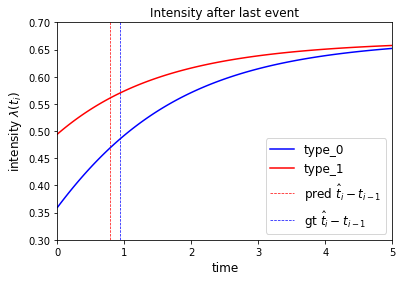

In [9]:
# Also we can plot some plots with intensity

plt.plot(dt, intensity[:,0], c = 'b', label='type_0')
plt.plot(dt, intensity[:,1], c ='r', label='type_1')

plt.vlines(time_pred, 0,1,linestyle='--', linewidth=.7, color='red',
                   label=r'pred $\hat{t}_i - t_{i-1}$')

plt.vlines(time_gt, 0,1,linestyle='--', linewidth=.7, color='b',
                   label=r'gt $\hat{t}_i - t_{i-1}$')
plt.ylim(0.3,0.7)
plt.xlim(0,5)
plt.legend(fontsize=12)
plt.xlabel('time', size=12)
plt.ylabel('intensity $\lambda(t_i)$', size=12)
plt.title('Intensity after last event')
plt.show()

In [26]:
# Evaluate model on the whole test set

time_mse_error_test, type_accuracy_test = evaluate_prediction(model, test_loader,device)

In [28]:
print('Mean MSE error of time estimation: ', time_mse_error_test)
print('Event type prediction accuracy: ', type_accuracy_test)

Mean MSE error of time estimation:  20.438137580788595
Event type prediction accuracy:  0.58
